In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate

### Druh konečného prvku, nainicializování bodů a vah Gaussovy-Legendreovy kvadratury

In [2]:
n = 3 # 1D intervaly (3 B-spline nasadove funkce na 1 konecny prvek)

line_o3_QP = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)], dtype=np.float64) # Gaussovy body
line_o3_QW = np.array([5/9, 8/9, 5/9], dtype=np.float64) # vahy

nqp = line_o3_QP.shape[0] # celkovy pocet pouzitych Gaussovych bodu

### Definice kvadratických B-spline násadových funkcí a jejich derivací na konečném prvku, definice lineárních násadových funkcí a jejich derivací na příslušném referenčním prvku

Lineární násadové funkce jsou použity pro zobrazení bodů referenčního prvku na body konkrétního konečného prvku.

In [3]:
def line3_N_e(knt: np.ndarray, ele_b_e: np.ndarray, r: np.ndarray) -> np.ndarray:

    return np.vstack((interpolate.BSpline.basis_element(knt[ele_b_e[0]:ele_b_e[0] + 4], False)(r),
                      interpolate.BSpline.basis_element(knt[ele_b_e[1]:ele_b_e[1] + 4], False)(r),
                      interpolate.BSpline.basis_element(knt[ele_b_e[2]:ele_b_e[2] + 4], False)(r)))

def line3_dNdX_e(knt: np.ndarray, ele_b_e: np.ndarray, r: np.ndarray) -> np.ndarray:

    return np.vstack((interpolate.BSpline.basis_element(knt[ele_b_e[0]:ele_b_e[0] + 4], False)(r, nu=1),
                      interpolate.BSpline.basis_element(knt[ele_b_e[1]:ele_b_e[1] + 4], False)(r, nu=1),
                      interpolate.BSpline.basis_element(knt[ele_b_e[2]:ele_b_e[2] + 4], False)(r, nu=1)))

def line_M(r: np.ndarray) -> np.ndarray:
    
    return np.vstack((0.5*(1-r), 0.5*(1+r)))

def line_dMdxi(r: np.ndarray) -> np.ndarray:
    
    return np.vstack((-0.5+0*r, 0.5+0*r))

### Definice funkce na pravé straně

In [4]:
def load_func(x: np.ndarray) -> np.ndarray:

    return np.sin(x)

### Výpočet hodnot lineárních násadových funkcí a hodnot jejich derivací v bodech Gaussovy-Legendreovy kvadratury

(kvůli zobrazení bodů referenčního prvku na body konkrétního konečného prvku)

In [5]:
line_o3_QP_M = line_M(line_o3_QP)

dMdxi = line_dMdxi(line_o3_QP)

### Sestavení příslušného uzlového vektoru, dekompozice výpočetní oblasti na konečné prvky

In [6]:
tmp = np.linspace(0, np.pi, 6)
knt = np.hstack((np.full(shape=2, fill_value=tmp[0]), tmp, np.full(shape=2, fill_value=tmp[-1]))) # uzlovy vektor

N = 6
ne = N - 1 # pocet pouzitych konecnych prvku
nn = N # pocet uzlu (tez uzlovych bodu)

ind_n = np.array([ i for i in range(nn) ], dtype=np.int64) # pole globalnich indexu uzlu
mesh_ele_n = np.column_stack((ind_n[0:-1], ind_n[1:])) # matice urcujici vztah mezi lokalnimi (na jednom konecnem prvku)
                                                       # a globalnimi indexy uzlu (zobrazeni l2g_nod)
xx = knt[2:-2]
mesh_coo_n = xx # uzly

nb = knt.shape[0] - 2 - 1 # pocet nasadovych funkci

ind_b = np.array([ i for i in range(nb) ], dtype=np.int64) # pole globalnich indexu nasadovych funkci
mesh_ele_b = np.column_stack((ind_b[:-2], ind_b[1:-1], ind_b[2:])) # matice urcujici vztah mezi lokalnimi (na jednom konecnem prvku)
                                                                   # a globalnimi indexy nasadovych funkci (zobrazeni l2g)

### Sestavení matice tuhosti a vektoru zatížení

In [7]:
K = np.zeros(shape=(nb, nb), dtype=np.float64)

f = np.zeros(shape=nb, dtype=np.float64)

for e in range(ne):
    ele_n_e = mesh_ele_n[e, :]
    ele_b_e = mesh_ele_b[e, :]

    p = mesh_coo_n[ele_n_e]
    P = np.zeros(shape=(2, nqp), dtype=np.float64)
    P.T[:, :] = p

    j = np.sum(P.T*dMdxi.T, axis=1) # hodnoty jakobianu zobrazeni Z^e v Gaussovych bodech

    detj = j # hodnoty determinantu jakobianu zobrazeni Z^e v Gaussovych bodech
    absdetj = np.abs(detj)

    line_o3_QP_e = p @ line_o3_QP_M # zobrazeni Gaussovych bodu na konecny prvek
    dNdX = line3_dNdX_e(knt, ele_b_e, line_o3_QP_e)

    tmp = (dNdX*absdetj*line_o3_QW) @ dNdX.T # lokalni matice tuhosti
    Kloc_flattened = tmp.flatten()

    tmp = np.ones(shape=n, dtype=np.int64)
    K_ind_i = np.kron(ele_b_e, tmp)
    K_ind_j = np.kron(tmp, ele_b_e)
    K[K_ind_i, K_ind_j] += Kloc_flattened

    line_o3_QP_N = line3_N_e(knt, ele_b_e, line_o3_QP_e)
    line_o3_QP_load_func = load_func(line_o3_QP_e)
    floc = (line_o3_QP_load_func*absdetj*line_o3_QW) @ line_o3_QP_N.T # lokalni vektor zatizeni

    f[ele_b_e] += floc

print(np.linalg.norm(K @ np.ones(shape=nb))) # test

6.497413668604471e-16


### Zahrnutí Dirichletovy okrajové podmínky, sestavení a vyřešení příslušné soustavy

In [8]:
nbd = 2 # pocet nasadovych funkci majicich nenulovou stopu na Gamma_D
ind_bd = np.array([ind_b[0], ind_b[-1]], dtype=np.int64) # globalni indexy nasadovych funkci majicich nenulovou stopu na Gamma_D

g = np.array([1.2, 1.7], dtype=np.float64)

B = np.zeros(shape=(nbd, nb), dtype=np.float64)
B[[ i for i in range(nbd) ], ind_bd] = 1

A = np.zeros(shape=(nb + nbd, nb + nbd), dtype=np.float64)
A[0:nb, 0:nb] = K
A[nb:, 0:nb] = B
A[0:nb, nb:] = B.T

b = np.zeros(shape=(nb + nbd), dtype=np.float64)
b[0:nb] = f
b[nb:] = g

iga_sol_c = np.linalg.solve(A, b)[0:nb]

### Vykreslení přibližného řešení, porovnání s přesným řešením

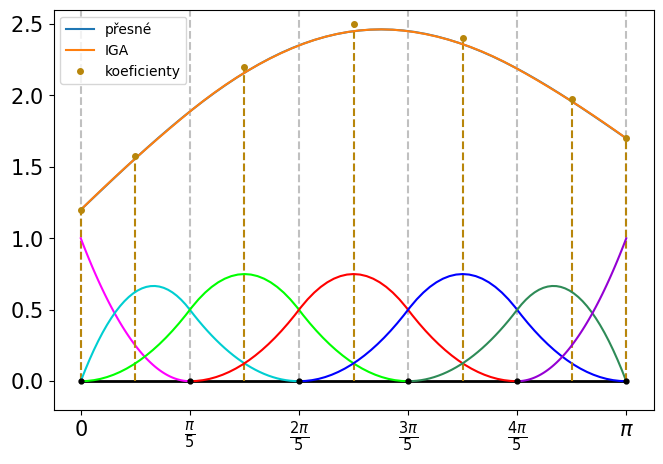

In [9]:
plot_mesh_tru_sol = np.linspace(0, np.pi, 50)
plot_mesh_tru_sol_v = np.sin(plot_mesh_tru_sol) + (0.5/np.pi)*plot_mesh_tru_sol + 1.2

plot_mesh_iga_sol = np.linspace(0, np.pi, 50)
plot_mesh_iga_sol_v = interpolate.BSpline(t=knt, c=iga_sol_c, k=2, extrapolate=False)(plot_mesh_iga_sol)

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0, 0, 1, 1])
ymin, ymax = -0.2, 2.6
ax.set_ylim(ymin=ymin, ymax=ymax)
ax.plot(plot_mesh_tru_sol, plot_mesh_tru_sol_v, label="přesné")

n_nod = nn
ax.plot([0, np.pi], [0, 0], color="black", lw=2)
for i in range(n_nod):
    ax.plot([mesh_coo_n[i], mesh_coo_n[i]], [0, ymax], linestyle="--", color="silver")

n_bas = nb
expts_bas = np.array([ (knt[i + 2] + knt[i + 1])/2 for i in range(n_bas) ], dtype=np.float64)
ctrlp_bas = np.zeros(shape=n_bas)
colors_bas = ["magenta", "darkturquoise", "lime", "red", "blue", "seagreen", "darkviolet"]
for i in range(n_bas):
    ax.plot([expts_bas[i], expts_bas[i]], [0, iga_sol_c[i]], linestyle="--", color="darkgoldenrod")

    plot_mesh_bas = np.linspace(knt[i], knt[i + 3], 51)
    ctrlp_bas[i] = 1
    ax.plot(plot_mesh_bas,
            interpolate.BSpline(t=knt, c=ctrlp_bas, k=2, extrapolate=False)(plot_mesh_bas),
            color=colors_bas[i])
    ctrlp_bas[i] = 0

ax.plot(mesh_coo_n, np.zeros(shape=n_nod), 'k.', markersize=7)

ax.plot(plot_mesh_iga_sol, plot_mesh_iga_sol_v, label="IGA")
ax.plot(expts_bas, iga_sol_c, linestyle="None", marker="o", markersize=4, color="darkgoldenrod", label="koeficienty")
ax.legend()

ax.set_xticks([0, (1/5)*np.pi, (2/5)*np.pi, (3/5)*np.pi, (4/5)*np.pi, np.pi])
ax.set_xticklabels([r'$0$', r'$\frac{\pi}{5}$', r'$\frac{2\pi}{5}$', r'$\frac{3\pi}{5}$', r'$\frac{4\pi}{5}$', r'$\pi$'], fontsize=15)
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2, 2.5])
ax.set_yticklabels([r'$0.0$', r'$0.5$', r'$1.0$', r'$1.5$', r'$2.0$', r'$2.5$'], fontsize=15)

plt.show()